#### Static Word Embedding
### **word2vec**

there are two variants in word2vec models

[to prepare embedding layers weights training
two variants varies in their datapipeline, other than model architecture and training are mostly similar]: #

+ continuous bag of words [CBOW] 
    - trying to minimize the loss function for given training sample prepared using the target word and neighboring words (context)
+ continuous skipgram
    - opposite to CBOW, trying to find the best parameters of embedding layers for given the neighboring words (context) and target word[a bit unclear, will be updated soon]

Sources:
- [Good Starting Point - Word2Vec - Tensorflow](https://www.tensorflow.org/text/tutorials/word2vec)
- [Great Source On NLP - Standford](https://web.stanford.edu/class/cs224n/)
- [Maths behind Word2Vec](https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf)
- [Candidate Sampling - Negative Sampling](https://www.tensorflow.org/extras/candidate_sampling.pdf)
- [Not important - tf.data.Dataset](https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html?_gl=1*1jlc6kv*_ga*MTMyODM2NTQ2Ni4xNzU0NDU3MzI4*_ga_W0YLR4190T*czE3NTUxNzE2MjckbzkkZzEkdDE3NTUxNzE2OTkkajU5JGwwJGgw)

In [1]:
import io
import re
from tqdm import tqdm
import string
import random

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

# <font color="pink"> Skipgram </font>

## <font color="brown"> Own Implementation</font>
only for single sentence and can be scaled, however little bit preparation is necessary before

In [12]:
example = "The Wind has four directions and the Sun raises in one"
tokens = example.lower().split()
tokens

['the',
 'wind',
 'has',
 'four',
 'directions',
 'and',
 'the',
 'sun',
 'raises',
 'in',
 'one']

In [30]:
# encoding
vocab, index = {}, 1
vocab['<pad>'] = 0
for token in tokens:
    if token not in vocab:
        vocab[token] = index
        index += 1
vocab

{'<pad>': 0,
 'the': 1,
 'wind': 2,
 'has': 3,
 'four': 4,
 'directions': 5,
 'and': 6,
 'sun': 7,
 'raises': 8,
 'in': 9,
 'one': 10}

In [14]:
# decoding
inverse_vocab = {v: k for k, v in vocab.items()}
inverse_vocab

{0: '<pad>',
 1: 'the',
 2: 'wind',
 3: 'has',
 4: 'four',
 5: 'directions',
 6: 'and',
 7: 'sun',
 8: 'raises',
 9: 'in',
 10: 'one'}

In [15]:
# common for positive and negative pairs
window_size = 2
target_index = 7

In [16]:
# positive context pairs
positive_context_pairs = []
c_word = 0
while(tqdm(True)):
    context_pos = (target_index-window_size)+c_word
    if context_pos<1:
        context_pos = 1
        c_word += 1
    if (context_pos>0 and context_pos<len(vocab)):
        if (context_pos<(target_index-window_size) or context_pos>(target_index+window_size)):
            break
        if target_index!=context_pos:
            positive_context_pairs.append((target_index, context_pos))
        c_word += 1
    else:
        break

positive_context_pairs

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


[(7, 5), (7, 6), (7, 8), (7, 9)]

In [17]:
print(example, '|| - target: ', inverse_vocab[target_index])
for each in positive_context_pairs:
    print(f"{each} - ({inverse_vocab[each[0]]}, {inverse_vocab[each[1]]})")

The Wind has four directions and the Sun raises in one || - target:  sun
(7, 5) - (sun, directions)
(7, 6) - (sun, and)
(7, 8) - (sun, raises)
(7, 9) - (sun, in)


In [18]:
# negative context pairs
# repeation is allowed
num_n = 5 # number of negative pairs
negative_context_pairs = []
c_word = 0
pos_range=[target_index-window_size, target_index+window_size]
while(tqdm(True)):
    context_pos = random.randint(0, len(vocab)-1) #len(vocab)-1, bcz it is inclusive
    if context_pos<1: # padding is excluded
        continue
    # if (context_pos>0 and context_pos<len(vocab)):
    if (context_pos<(target_index-window_size) or context_pos>(target_index+window_size)):
        negative_context_pairs.append((target_index, context_pos))
    
    if len(negative_context_pairs)>num_n-1:
        break
    # c_word += 1
    

negative_context_pairs

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


[(7, 10), (7, 2), (7, 4), (7, 1), (7, 4)]

In [19]:
print(example, '|| - target: ', inverse_vocab[target_index])
for each in negative_context_pairs:
    print(f"{each} - ({inverse_vocab[each[0]]}, {inverse_vocab[each[1]]})")

The Wind has four directions and the Sun raises in one || - target:  sun
(7, 10) - (sun, one)
(7, 2) - (sun, wind)
(7, 4) - (sun, four)
(7, 1) - (sun, the)
(7, 4) - (sun, four)


In [ ]:
example_sequence = [vocab[word] for word in tokens]
example_sequence

[1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10]

## <font color="brown">Tensorflow Example</font>
#### Skipgram for 1 sentence

In [ ]:
window_size = 2
positive_skip_grams = tf.keras.preprocessing.sequence.skipgrams(
    example_sequence,
    vocabulary_size=len(vocab),  # vocal={'word': 1, 'sun': 2} etc, see above
    window_size=window_size,
    negative_samples=0,
    seed=42
)
print(len(positive_skip_grams[0]))
print(positive_skip_grams[0][:10])

38
[[4, 5], [9, 7], [4, 3], [8, 10], [9, 8], [8, 1], [4, 6], [3, 1], [7, 6], [8, 7], [7, 8], [2, 4], [4, 2], [6, 1], [2, 3], [1, 8], [6, 7], [1, 6], [5, 1], [10, 9], [8, 9], [7, 1], [1, 2], [10, 8], [5, 3], [6, 5], [2, 1], [9, 10], [7, 9], [1, 7], [1, 5], [3, 2], [3, 5], [5, 4], [5, 6], [6, 4], [1, 3], [3, 4]]


In [38]:
for target, context in positive_skip_grams[0][:5]:
  print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")

(4, 5): (four, directions)
(9, 7): (in, sun)
(4, 3): (four, has)
(8, 10): (raises, one)
(9, 8): (in, raises)


In [ ]:
target_word, context_word = positive_skip_grams[0][0]
# print(target_word, context_word)
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
# print(context_word)
negative_sampling_candidates=tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,
    num_true=1,
    num_sampled=num_ns,
    unique=True,
    range_max=len(vocab),
    seed=42,
    name='negative_sampling'
)
# print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates[0]])

LogUniformCandidateSampler(sampled_candidates=<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 1, 0, 8])>, true_expected_count=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.27400503]], dtype=float32)>, sampled_expected_count=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.3752803 , 0.58962286, 0.8050837 , 0.19476941], dtype=float32)>)
['has', 'the', '<pad>', 'raises']


In [58]:
# now prepare an tuple of one single training example

squeezed_context_class = tf.squeeze(context_class, 1)

context = tf.concat([squeezed_context_class, negative_sampling_candidates[0]], 0)

label = tf.constant([1]+[0]*num_ns, dtype="int64")

target = target_word

In [59]:
print(f"target_index    : {target}")
print(f"target_word     : {inverse_vocab[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context]}")
print(f"label           : {label}")

target_index    : 4
target_word     : four
context_indices : [5 3 1 0 8]
context_words   : ['directions', 'has', 'the', '<pad>', 'raises']
label           : [1 0 0 0 0]


In [60]:
print("target  :", target)
print("context :", context)
print("label   :", label)

target  : 4
context : tf.Tensor([5 3 1 0 8], shape=(5,), dtype=int64)
label   : tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


In [ ]:
# sampling_table[i] denotes the probability of sampling the i-th most common word in a dataset. 
# The function assumes a Zipf's distribution of the word frequencies for sampling
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
print(sampling_table)

[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558 ]


In [65]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=20)
print(sampling_table)

[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558  0.0171136  0.01822533
 0.01929662 0.02033198 0.02133515 0.02230924 0.02325687 0.02418031
 0.02508148 0.02596208]


#### Generating Training Data

In [99]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0,
          seed=42)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

#### Preparing Dataset for Training

In [69]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [70]:
with open(path_to_file) as f:
  lines = f.read().splitlines()
for line in lines[:20]:
  print(line)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.


In [71]:
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

In [73]:
import itertools
for ele in itertools.islice(text_ds.as_numpy_iterator(), 21):
    print(ele.decode('utf-8'))
    

First Citizen:
Before we proceed any further, hear me speak.
All:
Speak, speak.
First Citizen:
You are all resolved rather to die than to famish?
All:
Resolved. resolved.
First Citizen:
First, you know Caius Marcius is chief enemy to the people.
All:
We know't, we know't.
First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?
All:
No more talking on't; let it be done: away, away!
Second Citizen:
One word, good citizens.
First Citizen:
We are accounted poor citizens, the patricians good.


In [ ]:
# Looking into corpus for total unique words it has
unique_words = set()
for text in text_ds.as_numpy_iterator():
    unique_words.update(text.decode().split())
vocab_size = len(unique_words)
print(vocab_size)


25670


# <font color="red"> Preprocessing </font>
### Step 1: Vectorize the corpus & Build Vocabulary

In [ ]:
# Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096  # from the layer.adapt, will give the vocal size=12850, to see this comment max_tokens argument
sequence_length = 10

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    # output_sequence_length=sequence_length
    )

### <font color="yellow">Call TextVectorization.adapt on the text dataset to create vocabulary</font>

In [94]:
vectorize_layer.adapt(text_ds.batch(1024))

#### <font color="green">Once the state of the layer has been adapted to represent the text corpus, the vocabulary can be accessed with TextVectorization.get_vocabulary. This function returns a list of all vocabulary tokens sorted (descending) by their frequency.</font>

In [ ]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])
print(len(inverse_vocab))  # size of vocab

['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('to'), np.str_('i'), np.str_('of'), np.str_('you'), np.str_('my'), np.str_('a'), np.str_('that'), np.str_('in'), np.str_('is'), np.str_('not'), np.str_('for'), np.str_('with'), np.str_('me'), np.str_('it'), np.str_('be'), np.str_('your')]
12850


#### tokenzing the all sentences in the training corpus using vocabulary from vectorize_layer

In [82]:
# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(tf.data.AUTOTUNE).map(vectorize_layer).unbatch()

In [84]:
print(text_vector_ds)

<_UnbatchDataset element_spec=TensorSpec(shape=(10,), dtype=tf.int64, name=None)>


In [85]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

32777


In [86]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 89 270   0   0   0   0   0   0   0   0] => [np.str_('first'), np.str_('citizen'), '', '', '', '', '', '', '', '']
[138  36 982 144 673 125  16 106   0   0] => [np.str_('before'), np.str_('we'), np.str_('proceed'), np.str_('any'), np.str_('further'), np.str_('hear'), np.str_('me'), np.str_('speak'), '', '']
[34  0  0  0  0  0  0  0  0  0] => [np.str_('all'), '', '', '', '', '', '', '', '', '']
[106 106   0   0   0   0   0   0   0   0] => [np.str_('speak'), np.str_('speak'), '', '', '', '', '', '', '', '']
[ 89 270   0   0   0   0   0   0   0   0] => [np.str_('first'), np.str_('citizen'), '', '', '', '', '', '', '', '']


### Step 2: Generate training examples from sequences[tokenized using vocabulary]

In [100]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=42)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 32777/32777 [00:58<00:00, 564.33it/s]




targets.shape: (107193,)
contexts.shape: (107193, 5)
labels.shape: (107193, 5)


In [101]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [103]:
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print(dataset)

<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


### Model Training

In [104]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [105]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [107]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.2899 - loss: 1.6013
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.4801 - loss: 1.5031
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.4857 - loss: 1.3607
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.5289 - loss: 1.2454
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.5700 - loss: 1.1508
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.6085 - loss: 1.0687
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.6445 - loss: 0.9948
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.6780 - loss: 0.9273
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.7089 - loss: 0.8651
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.7371 - loss: 0.8078
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - accuracy: 0.7612 - loss: 0.7551
Epoch 12/20
104/104

In [ ]:
# please use terminal instead of notebook [tensorboard --logdir logs/train/]

# %load_ext tensorboard
# %tensorboard --logdir logs/train/


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Embedding lookup and analysis

In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

# <font color="pink"> Now prepare embeddings on new sentences.
Analysis on Standalone Vector Space and Contextual Vector Space </font>

In [152]:
new_sentence = tf.data.Dataset.from_tensors(["I love deep learning"])
for ele in new_sentence.as_numpy_iterator():
    print(type(ele[0]))
    print(ele[0].decode('utf-8'))
# token_ids = [word2id[word] for word in new_sentence.lower().split() if word in word2id]


<class 'bytes'>
I love deep learning


In [153]:
sentence_tokens=new_sentence.map(vectorize_layer)
for i in sentence_tokens.as_numpy_iterator():
    print(i)
    for j in i[0]:
        print(vectorize_layer.get_vocabulary()[j])

tokenized = list(sentence_tokens.as_numpy_iterator())[0][0]
tokenized

[[   5   77  594 3038]]
i
love
deep
learning


array([   5,   77,  594, 3038])

In [ ]:
# one can get list of words from given sentence, however getting them back from vocabulary is what need
decoded=[str(vectorize_layer.get_vocabulary()[i]) for i in tokenized]
decoded

['i', 'love', 'deep', 'learning']

### <font color="violet"> Use Trained Model to make embeddings for 
new sentence in both standalone(text->nummerical conversion) and context</font>

In [155]:
# there two kinds of embeddings
# 1. target embeddings
# 2. context embeddings
# we will look at 1
target_emd_lay=word2vec.get_layer('w2v_embedding')
context_emd_lay=word2vec.get_layer('embedding_1')

In [156]:
# Target
target_embs=target_emd_lay(tokenized)

# Context
context_embs=context_emd_lay(tokenized)

print(f"target shape: {target_embs.shape}")
print(f"context shape: {context_embs.shape}")

target shape: (4, 128)
context shape: (4, 128)


In [ ]:
target_embs[:10]

<tf.Tensor: shape=(4, 128), dtype=float32, numpy=
array([[-0.03212512, -0.02179386,  0.01279657,  0.02571198,  0.02446023,
        -0.01956969, -0.02043103,  0.01412518, -0.03446918,  0.04737002,
         0.03609223, -0.0464257 , -0.04460065,  0.01509662, -0.0090661 ,
         0.0329846 ,  0.03908226,  0.02925802, -0.00511322,  0.01447273,
         0.03795232, -0.00736177,  0.04265875,  0.02203096, -0.01442593,
         0.03334821, -0.04396994,  0.0420073 ,  0.00151787,  0.02998022,
        -0.04623155,  0.02279265,  0.03811213,  0.04596433, -0.04903488,
        -0.02281567,  0.04702022,  0.04379613, -0.00981277, -0.0329138 ,
        -0.03585992, -0.03649987, -0.04533822, -0.01213319,  0.04575283,
         0.02303899,  0.00988616,  0.02197285,  0.04268357,  0.0411021 ,
         0.00700694, -0.00905206,  0.04957546, -0.04638374, -0.00917389,
         0.03377844,  0.0244273 ,  0.03124393, -0.04809124,  0.02430962,
         0.0181296 , -0.01149137,  0.02327207, -0.03822088, -0.02399576,
 

In [ ]:
context_embs[:10]

<tf.Tensor: shape=(4, 128), dtype=float32, numpy=
array([[-0.09937882,  0.13276935, -0.4956194 , -0.25396094,  0.70670146,
        -0.07848328, -0.38776493, -0.03876241,  0.31383228, -0.28646308,
         0.18866056, -0.49345902, -0.27018556, -0.12933706,  0.5066044 ,
         0.28965637,  0.30566603, -0.5009914 ,  0.33325362, -0.19029553,
        -0.32027036, -1.1237525 , -0.34902465,  0.11343108,  0.4994895 ,
         0.0186659 ,  0.01168205, -0.2645499 , -0.2375594 , -0.3047277 ,
         0.41372842, -0.08208462, -0.46861744, -0.12807937,  0.08641039,
         0.32863796, -0.41861024, -0.9962538 ,  0.47815955,  0.3253174 ,
        -0.5656903 ,  0.20907511, -0.10353153, -0.03789073, -0.50455225,
         0.00617176,  0.36901692,  0.21651784,  0.53306717, -0.31667882,
         0.4547756 ,  0.42521578, -0.08231268, -0.8486399 , -0.39255765,
         0.3345214 , -0.47555205, -0.42346537,  0.44202018, -0.719295  ,
         0.01972652, -0.4806468 , -0.30009192, -0.6085402 , -0.42445624,
 

# PCA

In [159]:
from sklearn.decomposition import PCA

def pca_dims_of_embs(embs):

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embs)
    print("Reduced shape:", reduced_embeddings.shape)  # (num_sentences, 2)
    return reduced_embeddings
    

In [160]:
reduced_embeddings_target=pca_dims_of_embs(target_embs)

Reduced shape: (4, 2)


In [161]:
reduced_embeddings_context=pca_dims_of_embs(context_embs)

Reduced shape: (4, 2)


# Plot their relation in vector space

In [165]:
import matplotlib.pyplot as plt

def plot_vector_embs(reduced_embeddings, decoded, title):
    plt.figure(figsize=(8,6))
    plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], color='blue')

    # Annotate points with the sentences
    for i, sentence in enumerate(reduced_embeddings):
        plt.annotate(decoded[i], (reduced_embeddings[i,0], reduced_embeddings[i,1]))

    plt.title(title)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.grid(True)
    plt.show()


# <font color="red"> Target Vector Space </font>

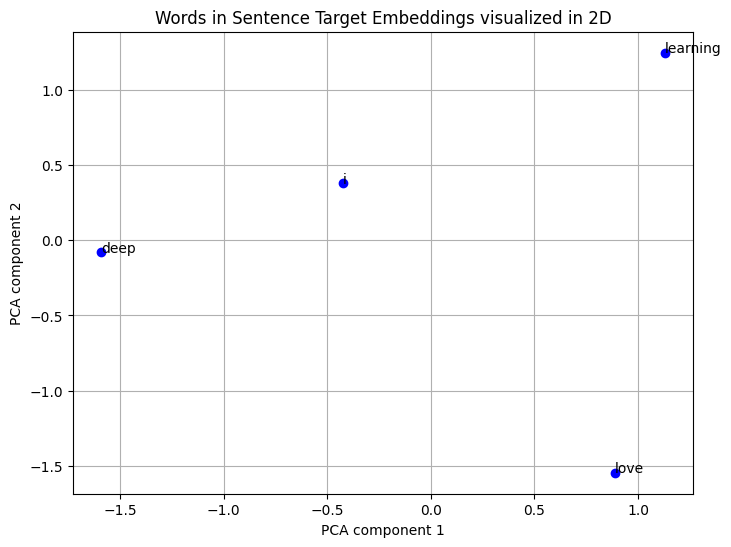

In [166]:
plot_vector_embs(reduced_embeddings=reduced_embeddings_target,
                 decoded=decoded,
                 title="Words in Sentence Target Embeddings visualized in 2D")

# <font color="red"> Context Vector Space </font>
if two words are contextually matched or similar, then we can see them lie very closely in vector space: here [deep, learning]

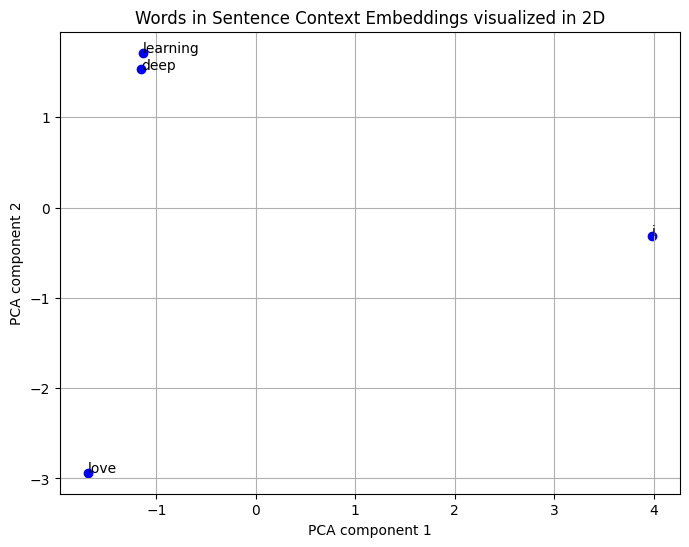

In [167]:
plot_vector_embs(reduced_embeddings=reduced_embeddings_context,
                 decoded=decoded,
                 title="Words in Sentence Context Embeddings visualized in 2D")